In [1]:
import time

import jax
import jax.numpy as jnp
from jax import lax, jit
from evosax import CMA_ES, SimAnneal

import matplotlib.pyplot as plt

from utils import photon_env_dicts

In [2]:
# Seeding everything

seed = 30

In [10]:
# Defining Sherbrooke Params and RL Params

tau_0 = 0.783
kappa = 14.31
chi = 0.31 * 2. * jnp.pi
kerr = 0.00
n0 = 53.8
res_amp_scaling = 1/0.348
actual_max_photons = n0 * (1. - 2. * jnp.cos(0.5 * chi * tau_0) * jnp.exp(-0.5 * kappa * tau_0) + jnp.exp(-0.5 * kappa * tau_0))
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.1
gamma_I = 1/362.9
photon_gamma = 1/4000
init_fid = 1.

time_coeff = 10.0
snr_coeff = 20.0
smoothness_coeff = 10.0
smoothness_baseline_scale = 1.0
apply_smoothing = True
use_processed_action = True
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 0.0
apply_bandwidth_constraint = False
num_t1 = 9.0
photon_weight = 12.0
shot_noise_std = 0.0
standard_fid = 0.99

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "apply_smoothing": apply_smoothing,
    "use_processed_action": use_processed_action,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "apply_bandwidth_constraint": apply_bandwidth_constraint,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 3000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 128,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 53.8
Actual Max Photons: 53.711451977836106


In [11]:
env = photon_env_dicts()[config["ENV_NAME"]](**config["ENV_PARAMS"])

In [27]:
# Instantiate the Different Search Strategies

cma_strategy = CMA_ES(popsize=num_envs, num_dims=env.num_actions, elite_ratio=0.6)
cma_params = cma_strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)

sa_strategy = SimAnneal(popsize=num_envs, num_dims=env.num_actions)
print(sa_strategy.default_params)
sa_params = sa_strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu,
    temp_init=1.0,
    temp_limit=0.1,
    temp_decay=0.9999,
    boltzmann_const=5.0,
    sigma_init=0.03,
    sigma_limit=0.001,
    sigma_decay=0.9999,
)

sa_params

EvoParams(temp_init=1.0, temp_limit=0.1, temp_decay=0.999, boltzmann_const=5.0, sigma_init=0.03, sigma_limit=0.01, sigma_decay=1.0, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)


EvoParams(temp_init=1.0, temp_limit=0.1, temp_decay=0.9999, boltzmann_const=5.0, sigma_init=0.03, sigma_limit=0.001, sigma_decay=0.9999, init_min=-1, init_max=1, clip_min=-2.873563218390805, clip_max=2.873563218390805)

In [28]:
# Defining Custom Rollout

def single_evolutionary_rollout(rng, single_action):
    rng, _rng = jax.random.split(rng)
    init_obs, init_state = env.reset(_rng, env.default_params)

    rng, _rng = jax.random.split(rng)
    obs, state, reward, dones, info = env.step(
        _rng,
        init_state,
        single_action,
        env.default_params
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32), info

vmap_evolutionary_rollout = jax.jit(jax.vmap(single_evolutionary_rollout))
dummy_batch_action = jnp.tile(jnp.ones_like(env.ts_action), (num_envs, 1))

key = jax.random.PRNGKey(seed=seed)
rng, _rng = jax.random.split(key)
rng_vmap = jax.random.split(_rng, num_envs)

dummy_fitness = vmap_evolutionary_rollout(rng_vmap, dummy_batch_action)

%timeit dummy_fitness = vmap_evolutionary_rollout(rng_vmap, dummy_batch_action)

57.1 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Testing Simulated Annealing

In [29]:
rng = jax.random.PRNGKey(seed=seed)
rng, _rng = jax.random.split(rng)

sa_init_state = sa_strategy.initialize(_rng, sa_params)

def generation_func(rng, state):
    rng, rng_gen = jax.random.split(rng, 2)
    x, state = sa_strategy.ask(rng_gen, state, sa_params)
    rng, _rng = jax.random.split(rng, 2)
    rng_step = jax.random.split(_rng, num_envs)
    fitness, info = vmap_evolutionary_rollout(rng_step, x)
    state = sa_strategy.tell(x, fitness, state, sa_params)
    return (rng, state, info)

jitted_gen_func = jit(generation_func)

# Defining Update Func
def update_func(carry, _):
    _rng, state = carry
    _rng, state, info = jitted_gen_func(_rng, state)
    metric = info
    loss_metric = {
        "sigma": state.sigma,
        "temp": state.temp,
    }
    metric["loss metric"] = loss_metric
    # jax.debug.print("best fitness: {best}", best=state.best_fitness)
    return (_rng, state), metric

# Define your loop
@jax.jit
def run_loop(rng, state):
    init_value = (rng, state)
    final_value, run_metrics = lax.scan(update_func, init_value, jnp.zeros(num_updates))
    _, final_state = final_value
    return run_metrics, final_state

# Run the loop
print(f"Starting Run of {num_updates} Updates")
start = time.time()
run_metrics, final_state = run_loop(_rng, sa_init_state)
print(f"Time Taken for {num_updates} updates: {time.time() - start}")

Starting Run of 3000 Updates
Time Taken for 3000 updates: 188.66783094406128


In [24]:
sa_rewards = run_metrics["reward"]
sa_pFs = run_metrics["max pF"]
sa_photon_times = run_metrics["photon time"]
sa_smoothnesses = run_metrics["smoothness"]
sa_bandwidths = run_metrics["bandwidth"]
sa_actions = run_metrics["action"]
loss_metric = run_metrics["loss metric"]
sa_sigma = loss_metric["sigma"]
sa_temp = loss_metric["temp"]

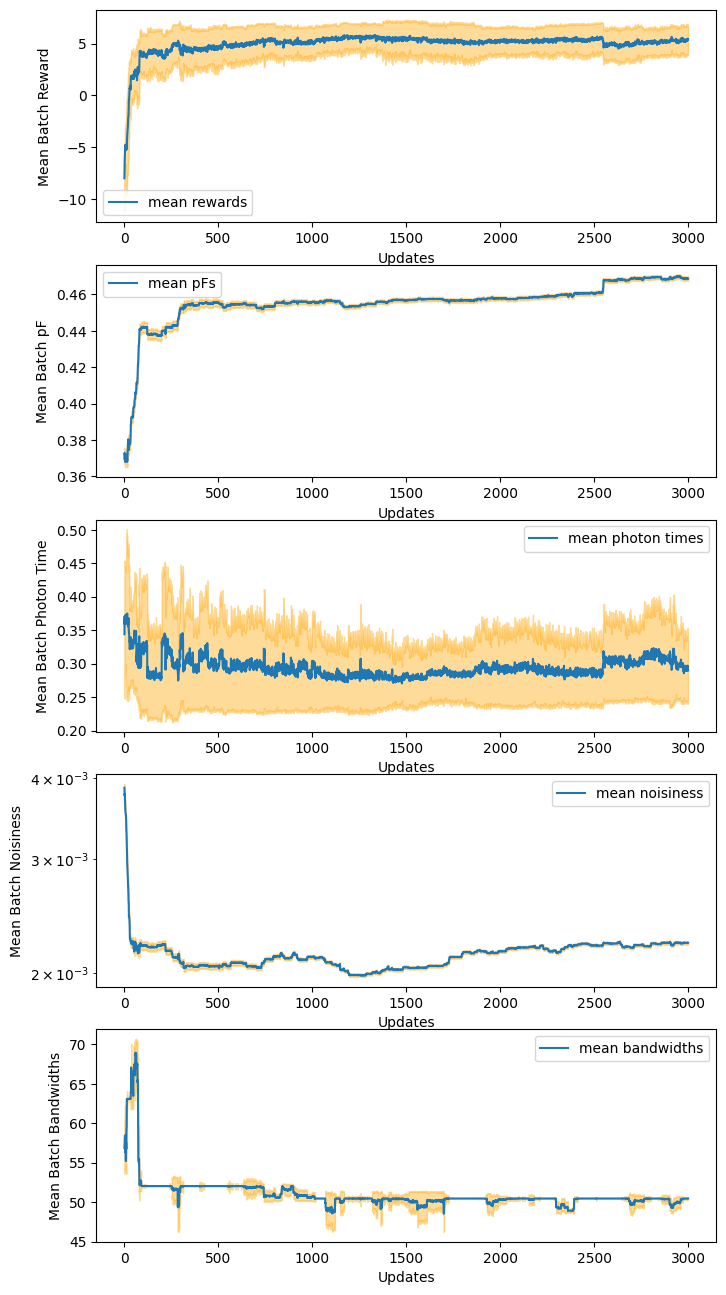

In [25]:
from utils import plot_learning

plot_learning(
    rewards=sa_rewards,
    max_pFs=sa_pFs,
    photon_times=sa_photon_times,
    smoothnesses=sa_smoothnesses,
    bandwidths=sa_bandwidths
)

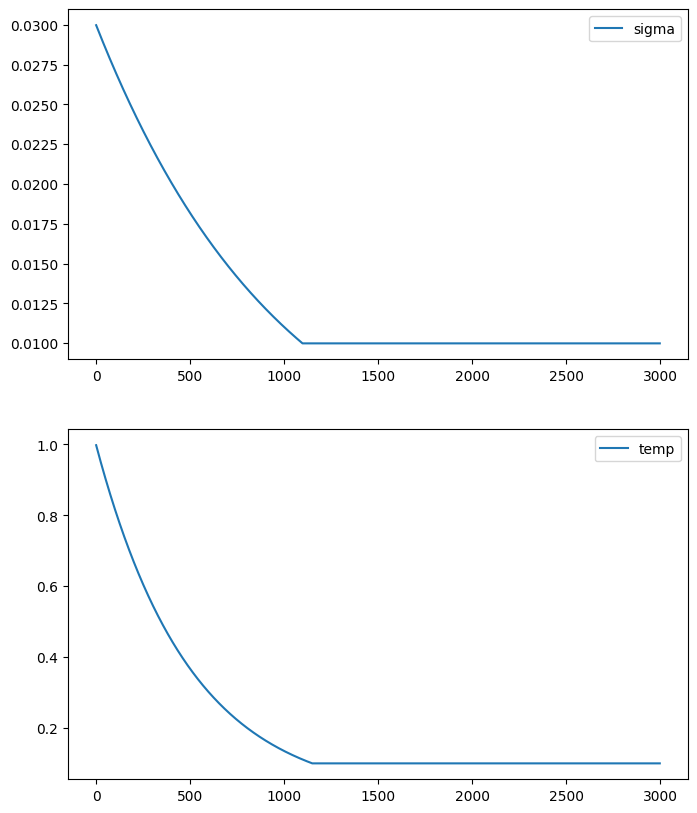

In [26]:
fig, ax = plt.subplots(2, figsize=(8.0, 10.0))

ax[0].plot(sa_sigma, label='sigma')
ax[0].legend()

ax[1].plot(sa_temp, label='temp')
ax[1].legend()

plt.show()

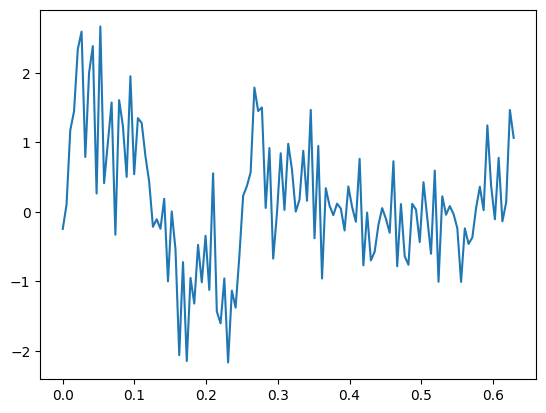

In [18]:
mean_final_action = jnp.mean(sa_actions, axis=1)[-1]

plt.plot(env.ts_action, mean_final_action)
plt.show()